## Imports

MMDetection and our library

In [3]:
import mmdet
from mmcv import Config
import pickle
import apr

import matplotlib
import matplotlib.pyplot as plt
from matplotlib import rcParams
import matplotlib.patches as patches
import matplotlib.lines as lines

Load the config file from MMDetection for SSD300

In [2]:
mmdetection_configs_root = '/home/Joe/MY/CV/CV_FINAL/anchor_pruning/TOOL/mmdetection/configs'
original_mmdet_ssd_config = f'{mmdetection_configs_root}/ssd/ssd300_coco.py'

cfg = Config.fromfile(original_mmdet_ssd_config)

Redefine the anchors by using our `PreciseAnchorGenerator` that allows each individual anchor to be specified.

To get the scale and ratio of every anchor of an existing MMDetection model use our tool in `tools/convert_mmdet_config.py`

In [3]:
!python /home/Joe/MY/CV/CV_FINAL/anchor_pruning/TOOL/anchor_pruning/tools/convert_mmdet_config.py {original_mmdet_ssd_config}

Converting Anchor Generator of file /home/Joe/MY/CV/CV_FINAL/anchor_pruning/TOOL/mmdetection/configs/ssd/ssd300_coco.py
Converting generator of the type SSDAnchorGenerator to PreciseAnchorGenerator.
{'type': 'SSDAnchorGenerator',
 'scale_major': False,
 'input_size': 300,
 'basesize_ratio_range': (0.15, 0.9),
 'strides': [8, 16, 32, 64, 100, 300],
 'ratios': [[2], [2, 3], [2, 3], [2, 3], [2], [2]]}
Old config used:
New config to be used:
{'_delete_': True,
 'type': 'PreciseAnchorGenerator',
 'strides': [8, 16, 32, 64, 100, 300],
 'scale_ratios': [[(0.07, 1.0), (0.1025, 1.0), (0.07, 0.5), (0.07, 2.0)],
                  [(0.15, 1.0),
                   (0.2225, 1.0),
                   (0.15, 0.5),
                   (0.15, 2.0),
                   (0.15, 0.3333),
                   (0.15, 3.0)],
                  [(0.33, 1.0),
                   (0.4102, 1.0),
                   (0.33, 0.5),
                   (0.33, 2.0),
                   (0.33, 0.3333),
                   (0.33, 3.

*The adjusted model config below is **not** compatible with the provided model checkpoint from MMDetection, the difference is in the order of anchors, we specify them in the same order as the original SSD paper which is different to the order of the MMDetection model.*

In [4]:
## https://github.com/Mxbonn/anchor_pruning/blob/master/configs/ssd/configuration_C.py

adjusted_model_cfg = dict(
    bbox_head=dict(
        anchor_generator=dict(
            _delete_=True,
            type='PreciseAnchorGenerator',
            strides=[8, 16, 32, 64, 100, 300],
            scale_ratios=(
                ((0.07, 1.0),),
                ((0.15, 1.0), (0.15, 3.0), (0.224, 1.0)),
                ((0.33, 1.0), (0.33, 2.0), (0.33, 3.0), (0.33, 1/3), (0.4102, 1.0)),
                ((0.51, 3.0), (0.51, 1/3), (0.5932, 1.0)),
                ((0.69, 2.0), (0.69, 0.5)),
                ((0.9557, 1.0),)
            ),
            anchor_base_size=300,
            centers=((4, 4), (8, 8), (16, 16), (32, 32), (50, 50), (150, 150))
        )
    )
)
cfg.merge_from_dict(adjusted_model_cfg)

The required input for our anchor pruning script is a directory with a checkpoint of the model named `best_checkpoint.pth` and a single `.py` config file. So lets create that:

In [5]:
#! mkdir pruning_directory

In [6]:
# Download ssd_baseline.pth from https://cloud.ilabt.imec.be/index.php/s/ERxYsRMidPEgNwT
# ! cp /home/Joe/MY/anchor/MODEL/ssd_baseline.pth /home/Joe/MY/anchor/pruning_directory/best_checkpoint.pth
# ! cp /home/Joe/MY/anchor/anchor_pruning/configs/ssd/baseline.py /home/Joe/MY/anchor/pruning_directory

And then run our tool:

In [7]:
! python /home/Joe/MY/CV/CV_FINAL/anchor_pruning/TOOL/anchor_pruning/tools/prune_anchors.py -i /home/Joe/MY/CV/CV_FINAL/anchor_pruning/pruning_directory -o /home/Joe/MY/CV/CV_FINAL/anchor_pruning/pruning_directory/pruning_results.pickle

loading annotations into memory...
Done (t=0.23s)
creating index...
index created!
{'type': 'SingleStageDetector', 'backbone': {'type': 'SSDVGG', 'depth': 16, 'with_last_pool': False, 'ceil_mode': True, 'out_indices': (3, 4), 'out_feature_indices': (22, 34), 'init_cfg': {'type': 'Pretrained', 'checkpoint': 'open-mmlab://vgg16_caffe'}}, 'neck': {'type': 'SSDNeck', 'in_channels': (512, 1024), 'out_channels': (512, 1024, 512, 256, 256, 256), 'level_strides': (2, 2, 1, 1), 'level_paddings': (1, 1, 0, 0), 'l2_norm_scale': 20}, 'bbox_head': {'type': 'SSDHead', 'in_channels': (512, 1024, 512, 256, 256, 256), 'num_classes': 80, 'anchor_generator': {'type': 'PreciseAnchorGenerator', 'strides': [8, 16, 32, 64, 100, 300], 'scale_ratios': (((0.07, 1.0),), ((0.15, 1.0), (0.15, 3.0), (0.224, 1.0)), ((0.33, 1.0), (0.33, 2.0), (0.33, 3.0), (0.33, 0.3333333333333333), (0.4102, 1.0)), ((0.51, 3.0), (0.51, 0.3333333333333333), (0.5932, 1.0)), ((0.69, 2.0), (0.69, 0.5)), ((0.9557, 1.0),)), 'anchor_base_si

In [5]:
with open('/home/Joe/MY/CV/CV_FINAL/anchor_pruning/pruning_directory_config_c_fin/pruning_results.pickle', 'rb') as map_results_file:
    results = pickle.load(map_results_file)
results['pareto_front'] = list(reversed(sorted(results['pareto_front'], key=lambda k: k['mAP']))) # sort pareto front on mAP

`results` is a dictionary that consists of a list of the pareto front of anchor configurations that are optimal to prune.
Based on the mAP and the #mac operation one can choose which pruned configuration one would like to use.
Below we plot the pareto frontier of pruned configurations.

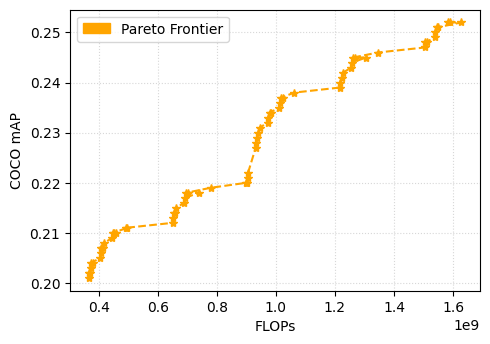

In [7]:
fig = plt.figure(1, figsize=(5,3.54331))
ax = plt.subplot(111)
ax.set_xlabel('FLOPs')
ax.set_ylabel('COCO mAP')

ax.plot([node['macs'] for node in results['pareto_front']], [node['mAP'] for node in results['pareto_front']],
       linestyle='--', marker='*', color='orange', markerfacecolor='orange', markersize=6)
legend_patches =  [patches.Patch(color='orange', label='Pareto Frontier')]
ax.set_xlabel('FLOPs')
ax.set_ylabel('COCO mAP')
ax.grid(linestyle=':', alpha=0.5)
plt.legend(handles=legend_patches)
plt.tight_layout()
plt.show()

In [8]:
for node in results['pareto_front']:
    print(node['removed_anchors'], node['mAP'], node['macs'])

{10, 4} 0.252 1584149760
{4} 0.252 1589045760
set() 0.252 1628213760
{9, 4, 5} 0.251 1544981760
{4, 5} 0.251 1549877760
{9, 10, 4, 5} 0.25 1540085760
{4, 5, 9, 10, 12} 0.249 1538323200
{9, 4, 5, 7} 0.248 1505813760
{4, 5, 7} 0.248 1510709760
{4, 5, 7, 9, 13} 0.247 1504051200
{2} 0.246 1345420800
{2, 10, 4, 5} 0.245 1262188800
{2, 4, 5} 0.245 1267084800
{2, 4} 0.245 1306252800
{2, 4, 5, 9, 10} 0.244 1257292800
{2, 4, 5, 9, 10, 12} 0.243 1255530240
{2, 4, 5, 7} 0.242 1227916800
{2, 4, 5, 7, 9} 0.241 1223020800
{2, 4, 5, 7, 9, 10} 0.24 1218124800
{2, 4, 5, 7, 9, 10, 12} 0.239 1216362240
{2, 3} 0.238 1062627840
{3, 10, 2, 5} 0.237 1018563840
{2, 3, 5} 0.237 1023459840
{2, 3, 5, 9, 10} 0.236 1013667840
{2, 3, 5, 9, 10, 12} 0.235 1011905280
{2, 3, 5, 8, 10} 0.234 979395840
{2, 3, 5, 7} 0.234 984291840
{2, 3, 5, 8, 9, 10} 0.233 974499840
{2, 3, 5, 8, 9, 10, 12} 0.232 972737280
{2, 3, 5, 7, 8} 0.231 945123840
{2, 3, 5, 7, 8, 9} 0.23 940227840
{2, 3, 5, 7, 8, 9, 10} 0.229 935331840
{2, 3, 5, 7,

To convert these `removed_anchors` back to a configuration you remove the anchors corresponding to the indices indicated above.
For example Configuration A from the paper corresponds with the pruned configuration with the highest accuracy and becomes:

configuration A = {5, 7, 13, 16, 17, 19, 22, 25, 26, 27, 28})

scale_ratios=(

((0.07, 1.0), (0.07, 2.0), (0.07, 0.5), (0.1024, 1.0)),

((0.15, 1.0), ~~(0.15, 2.0)~~, (0.15, 3.0), ~~(0.15, 0.5)~~, (0.15, 1 / 3), (0.224, 1.0)),

((0.33, 1.0), (0.33, 2.0), (0.33, 3.0), ~~(0.33, 0.5)~~, (0.33, 1 / 3), (0.4102, 1.0)),

(~~(0.51, 1.0), (0.51, 2.0)~~, (0.51, 3.0), ~~(0.51, 0.5)~~, (0.51, 1 / 3), (0.5932, 1.0)),

(~~(0.69, 1.0)~~, (0.69, 2.0), (0.69, 0.5), ~~(0.7747, 1.0)~~),

(~~(0.87, 1.0), (0.87, 2.0), (0.87, 0.5),~~ (0.9557, 1.0)),
),

In [ ]:
adjusted_model_cfg = dict(
    model=dict(
        bbox_head=dict(
            anchor_generator=dict(
                _delete_=True,
                type='PreciseAnchorGenerator',
                strides=[8, 16, 32, 64, 100, 300],
                scale_ratios=(
                    ((0.07, 1.0), (0.07, 2.0), (0.07, 0.5), (0.1024, 1.0)),
                    ((0.15, 1.0), (0.15, 3.0), (0.15, 1/3), (0.224, 1.0)),
                    ((0.33, 1.0), (0.33, 2.0), (0.33, 3.0), (0.33, 1/3), (0.4102, 1.0)),
                    ((0.51, 3.0), (0.51, 1/3), (0.5932, 1.0)),
                    ((0.69, 2.0), (0.69, 0.5)),
                    ((0.9557, 1.0))
                    ),
                anchor_base_size=300,
                centers=((4, 4), (8, 8), (16, 16), (32, 32), (50, 50), (150, 150))
            )
        )
    )
)
cfg.merge_from_dict(adjusted_model_cfg)

To train these new configurations with MMDetection it is as simple as adding `import apr` to the scripts of MMDetection. Or you can use the scripts provided in our tools directory, which have done exactly that.